In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
import seaborn as sns

In [3]:
def remove_outliers(df, variable, threshold=1.5):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1

    outliers = (df[variable] < q1 - threshold * iqr) | (df[variable] > q3 + threshold * iqr)

    df_cleaned = df[~outliers]

    return df_cleaned

In [4]:
df = pd.read_excel('scraped_products.xlsx')
df['price'] = df['price'].str.replace(' zł', '').str.replace(' ', '').str.replace(',', '.').astype(float) #konwersja cen na odpowiedni format
df = df.fillna(0) # zapelnianie brakujacych informacji 0

df = remove_outliers(df, 'price', 1.5)
df = remove_outliers(df, 'year', 1)
df = remove_outliers(df, 'element', 2)
df = remove_outliers(df, 'figures', 2)

print(len(df))
df

378


,price,id,series,year,element,figures,manual,box
0,79.99,6234.0,Pirates,1991.0,35.0,1.0,1.0,0.0
1,109.99,6246.0,Pirates,1994.0,51.0,2.0,1.0,0.0
2,169.99,6247.0,Pirates,1992.0,22.0,3.0,1.0,0.0
4,159.99,6036.0,Castle,1995.0,64.0,2.0,1.0,0.0
7,269.99,6706.0,Western,1997.0,14.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...
495,69.99,6665.0,Town,1994.0,62.0,3.0,1.0,0.0
497,49.99,6537.0,Town,1994.0,44.0,1.0,1.0,0.0
498,49.99,6512.0,Town,1992.0,33.0,1.0,1.0,0.0
501,119.99,6017.0,Castle,1987.0,36.0,2.0,1.0,0.0


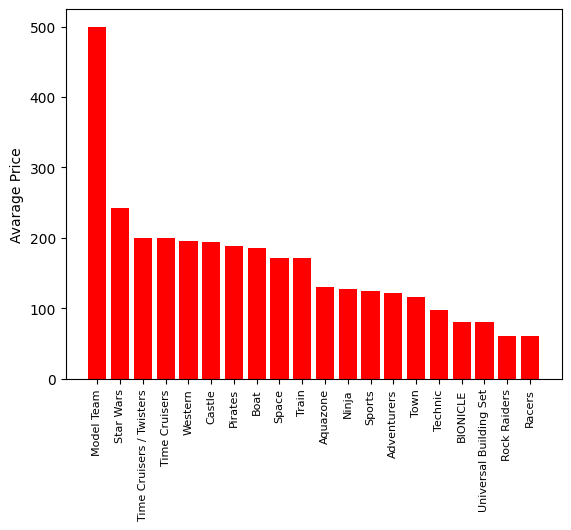

In [5]:
average_prices = df.groupby('series')['price'].mean().reset_index()
average_prices = average_prices.sort_values(by='price', ascending=False)
plt.bar(average_prices['series'], average_prices['price'], color='red')
plt.ylabel('Avarage Price')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.show()

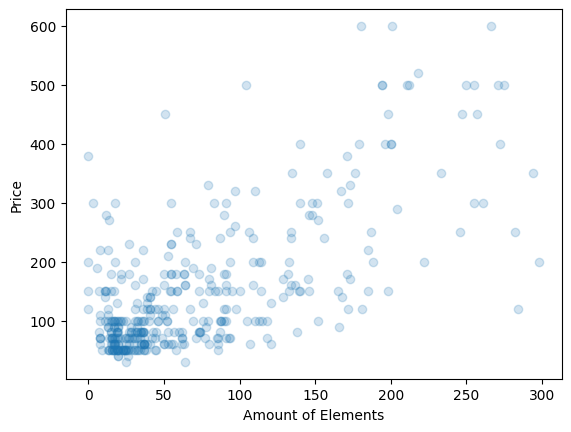

In [6]:
plt.scatter(df['element'], df['price'], alpha=0.2)
plt.xlabel('Amount of Elements')
plt.ylabel('Price')
plt.show()

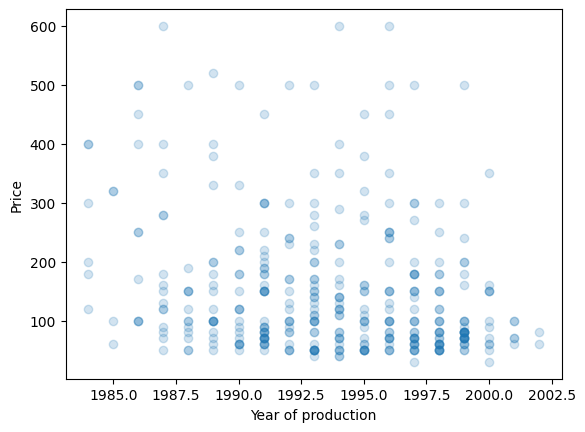

In [4]:
plt.scatter(df['year'], df['price'], alpha=0.2)
plt.xlabel('Year of production')
plt.ylabel('Price')
plt.show()

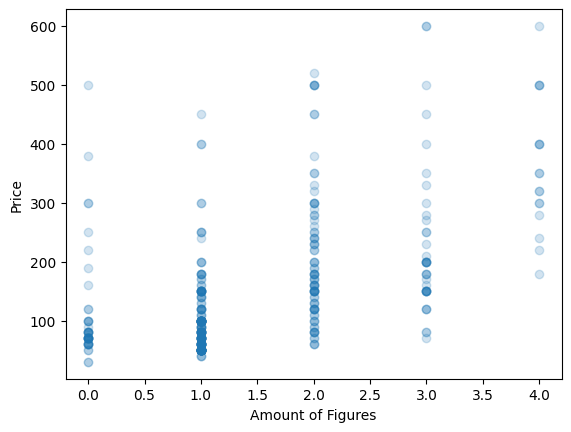

In [6]:
plt.scatter(df['figures'], df['price'], alpha=0.2)
plt.xlabel('Amount of Figures')
plt.ylabel('Price')
plt.show()

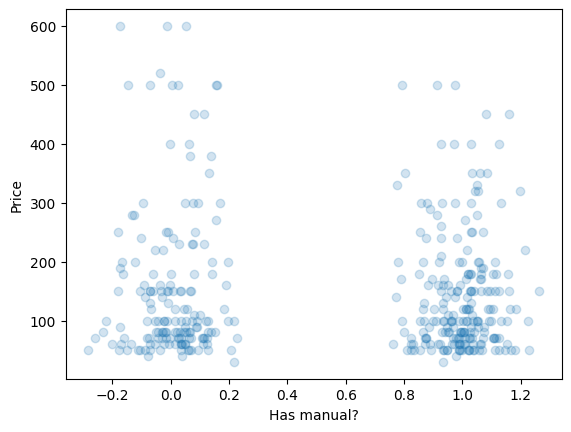

In [7]:
plt.scatter(df['manual']+np.random.normal(0, 0.1, size=len(df['manual'])), df['price'], alpha=0.2)
plt.xlabel('Has manual?')
plt.ylabel('Price')
plt.show()

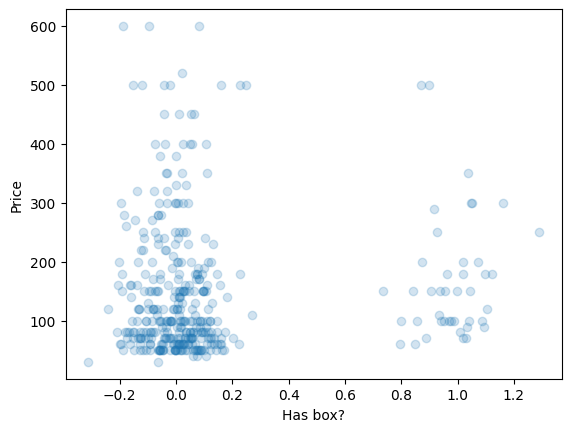

In [8]:
plt.scatter(df['box']+np.random.normal(0, 0.1, size=len(df['box'])), df['price'], alpha=0.2)
plt.xlabel('Has box?')
plt.ylabel('Price')
plt.show()

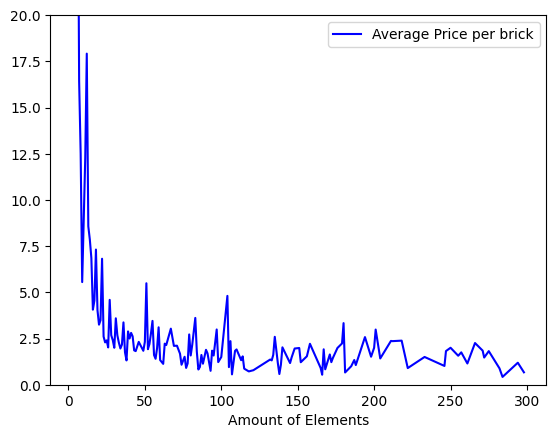

In [60]:
average_price_per_element = df.groupby('element')['price'].mean() / df.groupby('element')['element'].mean()
average_price_per_element = average_price_per_element.sort_index()
plt.plot(average_price_per_element.index, average_price_per_element.values, linestyle='-', color='blue', label='Average Price per brick')
plt.xlabel('Amount of Elements')
plt.legend()
plt.ylim(0, 20)
plt.show()

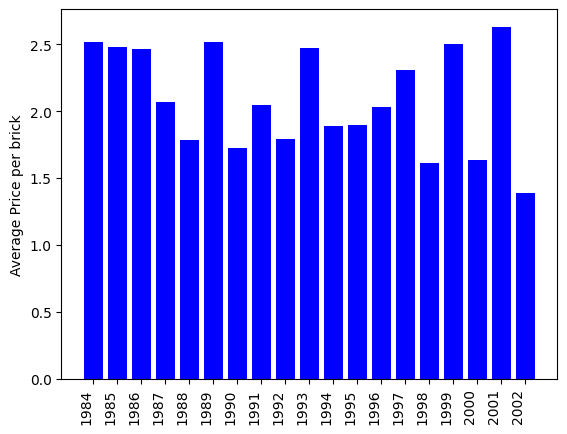

In [59]:
average_price_per_element_per_year = df.groupby('year')['price'].mean() / df.groupby('year')['element'].mean()
plt.bar(average_price_per_element_per_year.index, average_price_per_element_per_year.values, color='blue')
plt.ylabel('Average Price per brick')
years = average_price_per_element_per_year.index
plt.xticks(years, [f'{int(year)}' for year in years], rotation=90, ha='right')
plt.show()

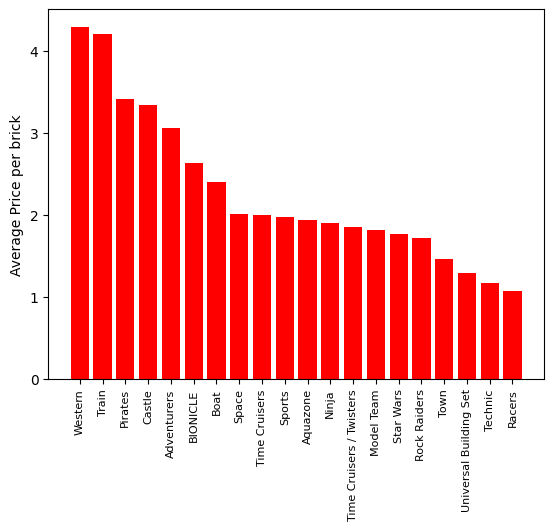

In [29]:
average_price_per_element_per_series = df.groupby('series')['price'].mean() / df.groupby('series')['element'].mean()
average_price_per_element_per_series = average_price_per_element_per_series.sort_values(ascending=False)

df['average_price_per_brick'] = df['series'].map(average_price_per_element_per_series)
df['estimated'] = df['average_price_per_brick'] * df['element']

plt.bar(average_price_per_element_per_series.index, average_price_per_element_per_series.values, color='red')
plt.ylabel('Average Price per brick')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.show()


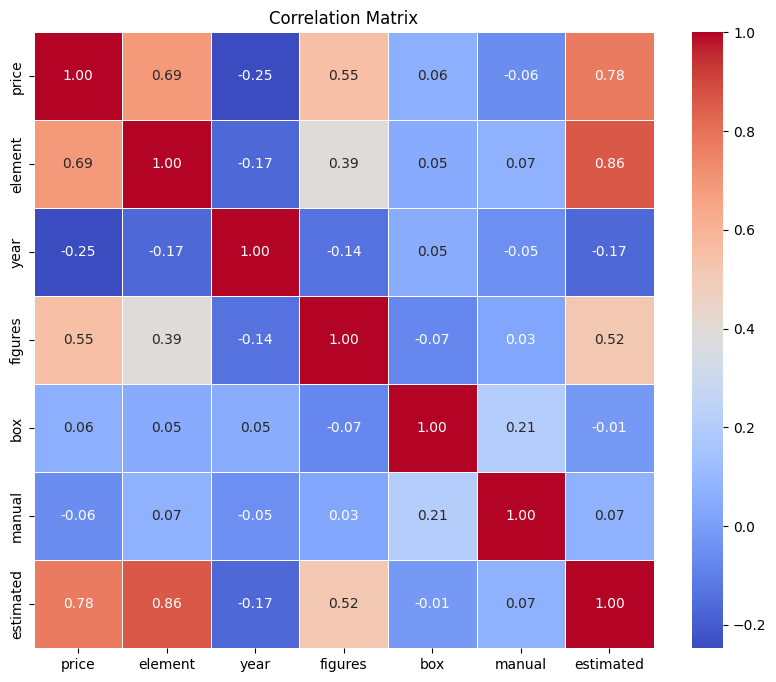

In [34]:
#macierz korelacji
correlation_matrix = df[['price', 'element', 'year', 'figures', 'box', 'manual', 'estimated']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:
#wybór najlepszego modelu
X = df[['year', 'element', 'figures', 'box', 'estimated']]
y = df['price']

model1 = LinearRegression()
model2 = DecisionTreeRegressor()
model3 = RandomForestRegressor()
model4 = SVR()
model5 = KNeighborsRegressor()
model6 = GradientBoostingRegressor()
model7 = MLPRegressor(hidden_layer_sizes=(100,), max_iter=100000, random_state=2137)
model8 = make_pipeline(PolynomialFeatures(2), LinearRegression())
model9 = make_pipeline(PolynomialFeatures(2), RandomForestRegressor())
model10 = make_pipeline(PolynomialFeatures(2), GradientBoostingRegressor())
model11 = make_pipeline(PolynomialFeatures(3), LinearRegression())
model12 = make_pipeline(PolynomialFeatures(3), RandomForestRegressor())
model13 = make_pipeline(PolynomialFeatures(3), GradientBoostingRegressor())

models = [model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13]

kf = KFold(n_splits=20, shuffle=True, random_state=3)

for model in models:
    from sklearn.model_selection import cross_val_score, KFold
    mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    avg=np.mean(-mse_scores)
    print(model,"Average MSE:", avg)

LinearRegression() Average MSE: 4712.971846453204
DecisionTreeRegressor() Average MSE: 7112.923976608188
RandomForestRegressor() Average MSE: 3942.9138515197856
SVR() Average MSE: 14667.010990017996
KNeighborsRegressor() Average MSE: 4855.81403508772
GradientBoostingRegressor() Average MSE: 4019.6071632484905
MLPRegressor(max_iter=100000, random_state=2137) Average MSE: 6611.677210030711
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())]) Average MSE: 4332.774137081779
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('randomforestregressor', RandomForestRegressor())]) Average MSE: 3855.4103062374097
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('gradientboostingregressor', GradientBoostingRegressor())]) Average MSE: 3973.159365420629
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression(

In [25]:
#podzial na dane uczace i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

#standaryzacja danych
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#tworzenie modelu
model = make_pipeline(PolynomialFeatures(3), GradientBoostingRegressor())
model.fit(X_train_scaled, y_train)

#testowanie modelu
y_pred = model.predict(X_test_scaled)

#sprawdzanie skutecznosci modelu
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

Mean Squared Error: 1608.5034245252514
Mean Absolute Error: 27.77201657907467
R-squared: 0.8760656230649871


In [37]:
#dane o zestawie klockow
box = 0
year = 1996
figures = 5
element = 201
series = 'Pirates'
#predykacja z uzyciem modelu
price_per_block = average_price_per_element_per_series[series] * element
new_data = {'year': [year], 'element': [element], 'figures': [figures], 'box': [box], 'estimated':[price_per_block]}
new_df = pd.DataFrame(new_data)
new_prediction = model.predict(scaler.transform(new_df))
print(f'Predicted Price: {new_prediction[0]}')

Predicted Price: 570.9574889242043
